In [1]:
from sklearn.metrics import classification_report

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.master("local").appName("Test Spark").getOrCreate()
sc=spark.sparkContext

In [4]:
from pyspark import SparkContext, SparkConf
import requests
import re

In [5]:
#load pyspark package and classes packages
import os
from pyspark.sql import SparkSession
import findspark

In [6]:
#setup spark session
findspark.init()

In [7]:
#import PYSPARK ML packages
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import DataFrame
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from pyspark import SparkConf, SparkContext

In [8]:
#defining spark object
spark = SparkSession.builder.appName("HDFS").getOrCreate()
sparkcont = SparkContext.getOrCreate(SparkConf().setAppName("HDFS"))
logs = sparkcont.setLogLevel("ERROR")
print("Spark Context Initialized")

Spark Context Initialized


In [9]:
#loadand display dataset values using spark context
dataset = spark.read.load("Dataset.csv",format="csv",inferSchema=True,header=True,delimiter='\t')
dataset = dataset.na.drop(how='any') #drop missing values
dataset.show() #show the dataset

+--------------------+-----+
|                text|label|
+--------------------+-----+
|"Great CD: My lov...|    1|
|One of the best g...|    1|
|Batteries died wi...|    0|
|works fine, but M...|    1|
|Great for the non...|    1|
|DVD Player crappe...|    0|
|Incorrect Disc: I...|    0|
|DVD menu select p...|    0|
|"Unique Weird Ori...|    1|
|"Not an ""ultimat...|    0|
|Great book for tr...|    1|
|Not!: If you want...|    0|
|"A complete Bust:...|    0|
|TRULY MADE A DIFF...|    1|
|didn't run off of...|    0|
|Don't buy!: First...|    0|
|Simple, Durable, ...|    1|
|Review of Kelly C...|    1|
|SOY UN APASIONADO...|    1|
|Some of the best ...|    1|
+--------------------+-----+
only showing top 20 rows



In [10]:
dataset.describe()

DataFrame[summary: string, text: string, label: string]

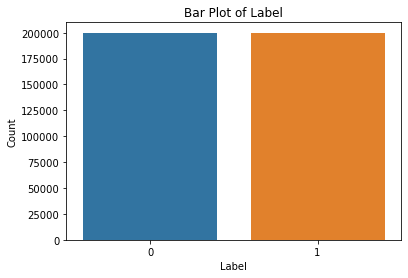

In [11]:
import seaborn as sns
# Select a categorical column for the bar plot
categorical_column = 'label'

# Compute frequency counts using Spark
count_df = dataset.groupBy(categorical_column).count().orderBy(categorical_column)

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df= count_df.toPandas()


# Create a bar plot using Seaborn
sns.barplot(data=pandas_df, x=categorical_column, y='count')
plt.title('Bar Plot of Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [12]:
import nltk

In [13]:
#wordcloud

In [14]:
#importing text preprocessing classes from pyspark packages whcih can be sued to remove stop words, special symbols
#and then convert text data into numeric vector
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from nltk.corpus import stopwords
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# tokenized text sentences into words
regex_Tokenizer = RegexTokenizer(inputCol="text",outputCol="words",pattern="\\W")
#get list of stop words
stop_words = stopwords.words('english')
#create stop words remover object using stop words list
stopwords_Remover = StopWordsRemover(inputCol="words",outputCol="filtered").setStopWords(stop_words)
#create count vector object to convert text into bag of words
count_Vectors = CountVectorizer(inputCol="filtered",outputCol="features", vocabSize=1000, minDF=5)
#label to convert target data into spark compatible format
label_string_Index = StringIndexer(inputCol="label",outputCol="target")
pipe_line = Pipeline(stages=[regex_Tokenizer, stopwords_Remover, count_Vectors, label_string_Index])
# now train the pipeline on training text.
pipeline_Fit = pipe_line.fit(dataset)
features = pipeline_Fit.transform(dataset)
features.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+------+
|                text|label|               words|            filtered|            features|target|
+--------------------+-----+--------------------+--------------------+--------------------+------+
|"Great CD: My lov...|    1|[great, cd, my, l...|[great, cd, lovel...|(1000,[0,1,2,3,4,...|   1.0|
|One of the best g...|    1|[one, of, the, be...|[one, best, game,...|(1000,[1,2,4,5,10...|   1.0|
|Batteries died wi...|    0|[batteries, died,...|[batteries, died,...|(1000,[5,7,11,20,...|   0.0|
|works fine, but M...|    1|[works, fine, but...|[works, fine, mah...|(1000,[20,78,180,...|   1.0|
|Great for the non...|    1|[great, for, the,...|[great, non, audi...|(1000,[2,11,17,32...|   1.0|
+--------------------+-----+--------------------+--------------------+--------------------+------+
only showing top 5 rows



In [15]:
# split dataset into train & test
(X_train, X_test) = features.randomSplit([0.7, 0.3], seed = 100)
print("70% dataset used for training : " + str(X_train.count()))
print("30% dataset used for testing  : " + str(X_test.count()))

70% dataset used for training : 279951
30% dataset used for testing  : 120049


In [16]:
#create random forest object and then train the model
rf_model = RandomForestClassifier(labelCol='target', seed=42)
rf_model.setFeaturesCol("features")
nb_Model = rf_model.fit(X_train) #train the model
nb_Predict = nb_Model.transform(X_test) #perform prediction on test data
correct_Label = nb_Predict.select(['target']).collect() #collect predicted labels
predicted_Label = nb_Predict.select(['prediction']).collect() #collect true labels
#now evaluate random forest performance and calculate accuracy
evaluate = MulticlassClassificationEvaluator(labelCol='target',metricName="accuracy")
print("---------------------------------------------------------------------------")
print("Random Forest Prediction Accuracy = "+str(evaluate.evaluate(nb_Predict)))
print("---------------------------------------------------------------------------\n")
print("---------------------------------------------------------------------------")
print('Classification Report (Random Forest)')
print("---------------------------------------------------------------------------")
#calculate preicision and other metrics
precisions=precision_score(correct_Label,predicted_Label,average='macro')
recalls=recall_score(correct_Label,predicted_Label,average='macro')
fmeasures=f1_score(correct_Label,predicted_Label,average='macro') 
print("Random Forest Precision : "+str(precisions))
print("Random Forest Perceptron Recall : "+str(recalls))
print("Random Forest Perceptron FScore : "+str(fmeasures))

---------------------------------------------------------------------------
Random Forest Prediction Accuracy = 0.7612558205399462
---------------------------------------------------------------------------

---------------------------------------------------------------------------
Classification Report (Random Forest)
---------------------------------------------------------------------------
Random Forest Precision : 0.7637412354107074
Random Forest Perceptron Recall : 0.761137707364737
Random Forest Perceptron FScore : 0.7606357735957969


In [17]:
print('Classification Report of Testing')
print(classification_report(correct_Label, predicted_Label))

Classification Report of Testing
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77     60169
         1.0       0.79      0.71      0.75     59880

    accuracy                           0.76    120049
   macro avg       0.76      0.76      0.76    120049
weighted avg       0.76      0.76      0.76    120049



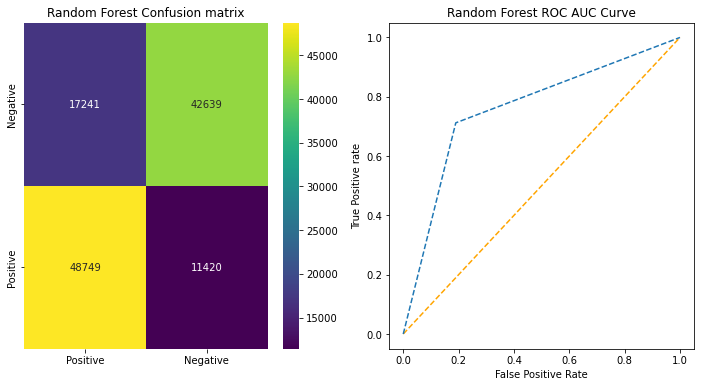

In [18]:
#plot random forest confusion matrix and roc graph
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

labels = ['Positive', 'Negative']
conf_matrix = confusion_matrix(correct_Label,predicted_Label)
fig, axs = plt.subplots(1,2,figsize=(12, 6))
ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
ax.set_ylim([0,len(labels)])
axs[0].set_title("Random Forest Confusion matrix") 
random_probs = [0 for i in range(len(correct_Label))]
p_fpr, p_tpr, _ = roc_curve(correct_Label, random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
ns_fpr, ns_tpr, _ = roc_curve(correct_Label, predicted_Label, pos_label=1)
axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
axs[1].set_title("Random Forest ROC AUC Curve")
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive rate')
plt.show()

In [19]:
#now perfrom prediction on test reviews using random forest object
#load test data
test_data = spark.read.load("testData.csv",format="csv",inferSchema=True,header=True,delimiter='\t')
test_data = test_data.na.drop(how='any')#drop missing values
test_data.show()

+--------------------+
|                text|
+--------------------+
|one of the last i...|
|Sony Hi8 Camcorde...|
|DVD Player crappe...|
|Incorrect Disc: I...|
|Don't buy!: First...|
|Long and boring: ...|
|Dont like it: Thi...|
|Don't Take the Ch...|
|Waste of money!: ...|
|works great: i bo...|
|Has No Range: I s...|
|"""True"" Nirvana...|
|garbage: Complete...|
|Not what I expect...|
+--------------------+



In [20]:
# convert test data into numeric features or vector
features = pipeline_Fit.transform(test_data)
features.show(6)

+--------------------+--------------------+--------------------+--------------------+
|                text|               words|            filtered|            features|
+--------------------+--------------------+--------------------+--------------------+
|one of the last i...|[one, of, the, la...|[one, last, serie...|(1000,[1,3,42,99,...|
|Sony Hi8 Camcorde...|[sony, hi8, camco...|[sony, hi8, camco...|(1000,[35,72,77,1...|
|DVD Player crappe...|[dvd, player, cra...|[dvd, player, cra...|(1000,[1,6,11,14,...|
|Incorrect Disc: I...|[incorrect, disc,...|[incorrect, disc,...|(1000,[1,4,5,10,1...|
|Don't buy!: First...|[don, t, buy, fir...|[buy, first, comp...|(1000,[1,12,14,16...|
|Long and boring: ...|[long, and, borin...|[long, boring, re...|(1000,[0,6,13,75,...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 6 rows



In [21]:
#perform prediction using random forest object and then get predicted label as positive or negative
nb_Predict = nb_Model.transform(features)
predicted_Label = nb_Predict.select(['prediction']).collect()
test_data = test_data.toPandas()
test_data = test_data.values
for i in range(len(predicted_Label)):
    if predicted_Label[i].prediction == 1:
        print(str(test_data[i,0])+" Predicted ====> POSITIVE")
    else:
        print(str(test_data[i,0])+" Predicted ====> NEGATIVE")
    print()    

one of the last in the series to collect !: The magazine was in very good condition and had the usual high standard of articles and photos that Victoria magazine has come to represent. I have collected all the previous magazines of the series and still enjoy leafing through them on a rainy day Predicted ====> POSITIVE

Sony Hi8 Camcorder with 2.5 LCD: I believe I will be very happy with the camcorder. Its small,light and easy to handle.The LCD is clear and bright.Ease of operation. Predicted ====> POSITIVE

DVD Player crapped out after one year: I also began having the incorrect disc problems that I've read about on here. The VCR still works, but hte DVD side is useless. I understand that DVD players sometimes just quit on you, but after not even one year? To me that's a sign on bad quality. I'm giving up JVC after this as well. I'm sticking to Sony or giving another brand a shot. Predicted ====> NEGATIVE

Incorrect Disc: I love the style of this, but after a couple years, the DVD is g